# Part 1: Setting everything up

If you are running this on colab run the next cell

In [ ]:
!pip install -q tensorflow keras kaggle matplotlib pillow scipy scikit-learn

Download your kaggle key json from
https://www.kaggle.com/settings -> (log in and there API -> Create new token)
Put the token on the current working folder

The json will have an structure like this

{"username" : "expositor", "key" : "ABCDEFGHIJKLMNOPQRS"}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# To make sure Kaggle library is working
!kaggle datasets list

ref                                                                 title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
mayankanand2701/zomato-stock-price-dataset                          Zomato Stock Price Dataset 📊🍗🏨🍴                      13KB  2024-05-23 06:42:34            890         23  1.0              
rahulvyasm/netflix-movies-and-tv-shows                              Netflix Movies and TV Shows                           1MB  2024-04-10 09:48:38          24276        517  1.0              
amanbarthwal/imdb-movies-data                                       IMDB Movies Dataset                                   8MB  2024-05-16 18:43:48           1871         35  1.0              
prasad22/weather-data                   

In [6]:
!kaggle datasets download sebastianfrancogomez/tarros-dataset-final-for-real

Dataset URL: https://www.kaggle.com/datasets/sebastianfrancogomez/tarros-dataset-final-for-real
License(s): GPL-2.0
 98%|███████████████████████████████████████▎| 933M/948M [00:09<00:00, 78.9MB/s]
100%|████████████████████████████████████████| 948M/948M [00:09<00:00, 99.5MB/s]


In [ ]:
!unzip tarros-dataset-final-for-real.zip
!rm tarros-dataset-final-for-real.zip

# Part 2: Current code to use

In [1]:
import tensorflow as tf
from tensorflow.keras import models, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model, clone_model
import matplotlib.pyplot as plt

from PIL import Image
import scipy

2024-05-27 02:22:04.877993: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 02:22:04.923785: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 02:22:04.923812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 02:22:04.924787: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-27 02:22:04.931636: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def generate_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(filters=16,kernel_size=3,padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), input_shape=(256,180,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.35))

    model.add(Conv2D(filters=32,kernel_size=3,padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.35))

    model.add(Conv2D(filters=64,kernel_size=3,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.35))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    return model

In [3]:
def generate_imagedatagen():
    train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.3,
        horizontal_flip = False
    )

    test_datagen = ImageDataGenerator(rescale = 1./255)

    return train_datagen, test_datagen

In [4]:
def generate_datagen(train_datagen, test_datagen):
    train_generator1 = train_datagen.flow_from_directory('DATASET_improved/1_front/train',
                                 target_size = (256,180),
                                 batch_size = 4,
                                 class_mode = "binary")

    validation_generator1 = test_datagen.flow_from_directory("DATASET_improved/1_front/validation",
                                 target_size = (256,180),
                                 batch_size = 1,
                                 class_mode = "binary")

    train_generator2 = train_datagen.flow_from_directory("DATASET_improved/2_back/train",
                                 target_size = (256,180),
                                 batch_size = 4,
                                 class_mode = "binary")

    validation_generator2 = test_datagen.flow_from_directory("DATASET_improved/2_back/validation",
                                 target_size = (256,180),
                                 batch_size = 1,
                                 class_mode = "binary")

    train_generator3 = train_datagen.flow_from_directory("DATASET_improved/3_up/train",
                                 target_size = (256,180),
                                 batch_size = 4,
                                 class_mode = "binary")

    validation_generator3 = test_datagen.flow_from_directory("DATASET_improved/3_up/validation",
                                 target_size = (256,180),
                                 batch_size = 1,
                                 class_mode = "binary")

    return train_generator1, validation_generator1, train_generator2, validation_generator2, train_generator3, validation_generator3

In [5]:
def generate_checkpoints():
    checkpoint1 = ModelCheckpoint('tarros_1.hdf5', monitor = "val_accuracy", verbose = 1, save_best_only = True)
    checkpoint2 = ModelCheckpoint('tarros_2.hdf5', monitor = "val_accuracy", verbose = 1, save_best_only = True)
    checkpoint3 = ModelCheckpoint('tarros_3.hdf5', monitor = "val_accuracy", verbose = 1, save_best_only = True)

    return checkpoint1, checkpoint2, checkpoint3

In [6]:
def train_model(model, train_generator, validation_generator, checkpoint, epochs):

    model.compile(loss = "binary_crossentropy",
             optimizer = 'rmsprop',
             metrics = ["accuracy"])

    hist = model.fit(train_generator,
                steps_per_epoch = 448//4,
                epochs = epochs,
                validation_data = validation_generator,
                validation_steps = 56//1,
                callbacks = [checkpoint])

    return hist

In [7]:
def plot_performance(hist, title):
    plt.plot(hist.history["accuracy"], label = "Train")
    plt.plot(hist.history["val_accuracy"], label = "Validation")
    plt.title(title)
    plt.legend()
    plt.show()
    plt.savefig(title)

In [8]:
def train_network():
    model1 = generate_model()
    model2 = clone_model(model1)
    model3 = clone_model(model1)

    train_datagen, test_datagen = generate_imagedatagen()

    train_generator1, validation_generator1, train_generator2, validation_generator2, train_generator3, validation_generator3 = generate_datagen(train_datagen, test_datagen)

    checkpoint1, checkpoint2, checkpoint3 = generate_checkpoints()

    hist1 = train_model(model = model1,
                        train_generator = train_generator1,
                        validation_generator = validation_generator1,
                        checkpoint = checkpoint1,
                        epochs = 6)
    plot_performance(hist1, 'front-side performance')

    hist2 = train_model(model = model2,
                        train_generator = train_generator2,
                        validation_generator = validation_generator2,
                        checkpoint = checkpoint2,
                        epochs = 6)
    plot_performance(hist2, 'back-side performance')

    hist3 = train_model(model = model3,
                        train_generator = train_generator3,
                        validation_generator = validation_generator3,
                        checkpoint = checkpoint3,
                        epochs = 6)
    plot_performance(hist3, 'up-side performance')

In [9]:
def test_model(model_name, directory):
    test_model = load_model(model_name)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_generator = test_datagen.flow_from_directory(directory,
                                 target_size = (256,180),
                                 batch_size = 1,
                                 class_mode = "binary")

    test_model.evaluate(test_generator)

In [10]:
train_network()

2024-05-27 02:22:15.473279: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 180, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 256, 180, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 90, 16)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 90, 16)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 90, 32)       4640      
                                                                 
 batch_normalization_1 (Bat  (None, 128, 90, 32)       1

2024-05-27 02:22:15.531459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 02:22:15.534463: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 02:22:15.538847: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

                                                                 
 conv2d_2 (Conv2D)           (None, 64, 45, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 22, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_2 (Bat  (None, 32, 22, 64)        256       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 32, 22, 64)        0         
                                                                 
 flatten (Flatten)           (None, 45056)             0         
                                                                 
 dense (Dense)               (None, 256)               11534592  
                                                                 
 batch_nor

2024-05-27 02:22:18.275727: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-27 02:22:19.107559: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-27 02:22:21.740457: I external/local_xla/xla/service/service.cc:168] XLA service 0x7b125c78ebc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-27 02:22:21.740490: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-05-27 02:22:21.779981: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1716776541.922000    2636 device_compiler.h:186] Compiled cluster using XLA!  This line i

 16/112 [===>..........................] - ETA: 30s - loss: 2.8595 - accuracy: 0.5469

KeyboardInterrupt: 

In [ ]:
test_model(model_name = './tarros_1.hdf5',
           directory = 'DATASET_improved/1_front/test')
test_model(model_name = './tarros_2.hdf5',
           directory = 'DATASET_improved/2_back/test')
test_model(model_name = './tarros_3.hdf5',
           directory = 'DATASET_improved/3_up/test')

# Part 3: Super new brand implementation

In [1]:
from keras.models import load_model, clone_model
import matplotlib.pyplot as plt
from PIL import Image
import scipy
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

2024-05-30 04:42:33.094857: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-30 04:42:33.438658: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 04:42:33.438690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 04:42:33.536659: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-30 04:42:33.651440: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def generate_imagedatagen():
    train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 10,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        zoom_range = 0.15,
        horizontal_flip = False,
        fill_mode = 'nearest',
    )

    test_datagen = ImageDataGenerator(rescale = 1./255)

    return train_datagen, test_datagen

In [3]:
def generate_datagen(train_datagen, test_datagen, batch_size = 16):
    train_generator1 = train_datagen.flow_from_directory('DATASET_improved/1_front/train',
                                 target_size = (64, 64),
                                 batch_size = batch_size,
                                 class_mode = "categorical",
                                 color_mode='grayscale')

    validation_generator1 = test_datagen.flow_from_directory("DATASET_improved/1_front/validation",
                                 target_size = (64, 64),
                                 batch_size = 1,
                                 class_mode = "categorical",
                                 color_mode='grayscale' )

    train_generator2 = train_datagen.flow_from_directory("DATASET_improved/2_back/train",
                                 target_size = (64, 64),
                                 batch_size = batch_size,
                                 class_mode = "categorical",
                                 color_mode='grayscale' )

    validation_generator2 = test_datagen.flow_from_directory("DATASET_improved/2_back/validation",
                                 target_size = (64, 64),
                                 batch_size = 1,
                                 class_mode = "categorical",
                                 color_mode='grayscale' )

    train_generator3 = train_datagen.flow_from_directory("DATASET_improved/3_up/train",
                                 target_size = (64, 64),
                                 batch_size = batch_size,
                                 class_mode = "categorical",
                                 color_mode='grayscale' )

    validation_generator3 = test_datagen.flow_from_directory("DATASET_improved/3_up/validation",
                                 target_size = (64, 64),
                                 batch_size = 1,
                                 class_mode = "categorical",
                                 color_mode='grayscale' )

    return train_generator1, validation_generator1, train_generator2, validation_generator2, train_generator3, validation_generator3

In [4]:
def calculate_class_weights(train_datagen):
    train_labels = []

    for i in range(len(train_datagen)):
        _, labels = train_datagen[i]
        train_labels.extend(np.argmax(labels, axis=1))

    train_labels = np.array(train_labels)

    unique, counts = np.unique(train_labels, return_counts=True)

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights_dict = dict(enumerate(class_weights))
    print("class count", dict(zip(unique, counts)))
    print("Class Weights:", class_weights_dict)
    return class_weights_dict


In [5]:
def generate_model(n_classes=2):
    model_regularizers = regularizers.l1_l2(l1=1e-3, l2=1e-3)
    model = tf.keras.Sequential()
    model.add(Conv2D(filters=16,kernel_size=3,padding='same', activation='relu', kernel_regularizer=model_regularizers, input_shape=(64,64,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.1))

    model.add(Conv2D(filters=32,kernel_size=3,padding='same', activation='relu', kernel_regularizer=model_regularizers))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.15))

    model.add(Conv2D(filters=64,kernel_size=3,padding='same', activation='relu', kernel_regularizer=model_regularizers))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.15))

    model.add(Conv2D(filters=128,kernel_size=3,padding='same', activation='relu', kernel_regularizer=model_regularizers))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.15))

    model.add(Flatten())

    model.add(Dense(16, kernel_regularizer=model_regularizers))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(32, kernel_regularizer=model_regularizers))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(64, kernel_regularizer=model_regularizers))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(n_classes, activation='softmax'))
    model.summary()

    return model

In [6]:
def generate_checkpoints():
    checkpoint1 = ModelCheckpoint('tarros_1.hdf5', monitor = "val_accuracy", verbose = 1, save_best_only = True)
    checkpoint2 = ModelCheckpoint('tarros_2.hdf5', monitor = "val_accuracy", verbose = 1, save_best_only = True)
    checkpoint3 = ModelCheckpoint('tarros_3.hdf5', monitor = "val_accuracy", verbose = 1, save_best_only = True)

    return checkpoint1, checkpoint2, checkpoint3

In [7]:
def train_model(model, train_generator, validation_generator, checkpoint, epochs, batch_size = 16):
    class_weights_dict = calculate_class_weights(train_generator)

    model.compile(loss = "categorical_crossentropy",
             optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-5),
             metrics = ["accuracy"])

    hist = model.fit(train_generator,
                steps_per_epoch = 448//batch_size,
                epochs = epochs,
                validation_data = validation_generator,
                shuffle=True,
                validation_steps = 56//1,
                callbacks = [checkpoint],
                class_weight=class_weights_dict)

    return hist

In [8]:
def plot_performance(hist, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(hist.history["accuracy"], label="Train Accuracy")
    ax1.plot(hist.history["val_accuracy"], label="Validation Accuracy")
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(hist.history["loss"], label="Train Loss")
    ax2.plot(hist.history["val_loss"], label="Validation Loss")
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    fig.suptitle(title)

    plt.show()
    fig.savefig(f'{title}.png')


In [9]:
def train_network():
    batch_size = 16
    model1 = generate_model()
    model2 = clone_model(model1)
    model3 = clone_model(model1)

    train_datagen, test_datagen = generate_imagedatagen()

    (train_generator1, validation_generator1,
     train_generator2, validation_generator2,
     train_generator3, validation_generator3) = generate_datagen(train_datagen, test_datagen, batch_size)

    checkpoint1, checkpoint2, checkpoint3 = generate_checkpoints()

    hist1 = train_model(model = model1,
                        train_generator = train_generator1,
                        validation_generator = validation_generator1,
                        checkpoint = checkpoint1,
                        epochs = 70,
                        batch_size = batch_size)
    plot_performance(hist1, 'front-side performance')

    hist2 = train_model(model = model2,
                        train_generator = train_generator2,
                        validation_generator = validation_generator2,
                        checkpoint = checkpoint2,
                        epochs = 70)
    plot_performance(hist2, 'back-side performance')

    hist3 = train_model(model = model3,
                        train_generator = train_generator3,
                        validation_generator = validation_generator3,
                        checkpoint = checkpoint3,
                        epochs = 70)
    plot_performance(hist3, 'up-side performance')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 64, 64, 16)        160       
                                                                 
 batch_normalization_49 (Ba  (None, 64, 64, 16)        64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 32, 32, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_50 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                      

/home/ubuntu/anaconda3/envs/speaking/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - ETA: 0s - loss: 5.6481 - accuracy: 0.5781
Epoch 2: val_accuracy did not improve from 0.50000
28/28 [==============================] - 40s 1s/step - loss: 5.6481 - accuracy: 0.5781 - val_loss: 5.5055 - val_accuracy: 0.5000
Epoch 3/70
28/28 [==============================] - ETA: 0s - loss: 5.7079 - accuracy: 0.5424
Epoch 3: val_accuracy did not improve from 0.50000
28/28 [==============================] - 46s 2s/step - loss: 5.7079 - accuracy: 0.5424 - val_loss: 5.5621 - val_accuracy: 0.5000
Epoch 4/70
28/28 [==============================] - ETA: 0s - loss: 5.7125 - accuracy: 0.5402
Epoch 4: val_accuracy did not improve from 0.50000
28/28 [==============================] - 46s 2s/step - loss: 5.7125 - accuracy: 0.5402 - val_loss: 5.6291 - val_accuracy: 0.5000
Epoch 5/70
28/28 [==============================] - ETA: 0s - loss: 5.7455 - accuracy: 0.5513
Epoch 5: val_accuracy did not improve from 0.50000
28/28 [==============================] - 47s

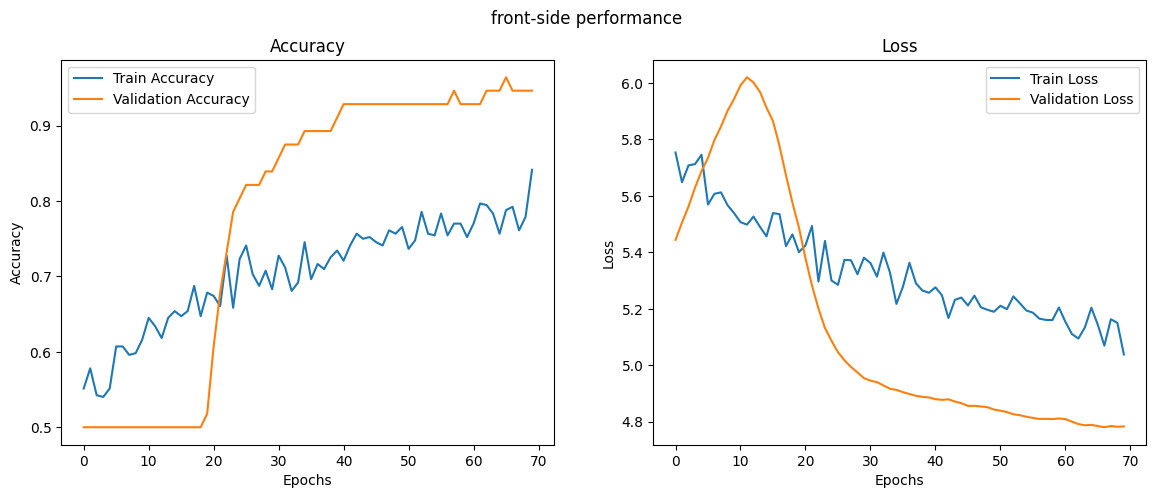

class count {0: 224, 1: 224}
Class Weights: {0: 1.0, 1: 1.0}
Epoch 1/70
28/28 [==============================] - ETA: 0s - loss: 5.8162 - accuracy: 0.5647
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to tarros_2.hdf5
28/28 [==============================] - 45s 1s/step - loss: 5.8162 - accuracy: 0.5647 - val_loss: 5.5681 - val_accuracy: 0.5000
Epoch 2/70


/home/ubuntu/anaconda3/envs/speaking/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - ETA: 0s - loss: 5.5723 - accuracy: 0.6138
Epoch 2: val_accuracy did not improve from 0.50000
28/28 [==============================] - 43s 2s/step - loss: 5.5723 - accuracy: 0.6138 - val_loss: 5.8502 - val_accuracy: 0.5000
Epoch 3/70
28/28 [==============================] - ETA: 0s - loss: 5.4768 - accuracy: 0.6719
Epoch 3: val_accuracy did not improve from 0.50000
28/28 [==============================] - 41s 1s/step - loss: 5.4768 - accuracy: 0.6719 - val_loss: 6.0985 - val_accuracy: 0.5000
Epoch 4/70
28/28 [==============================] - ETA: 0s - loss: 5.4569 - accuracy: 0.6741
Epoch 4: val_accuracy did not improve from 0.50000
28/28 [==============================] - 41s 1s/step - loss: 5.4569 - accuracy: 0.6741 - val_loss: 6.3558 - val_accuracy: 0.5000
Epoch 5/70
28/28 [==============================] - ETA: 0s - loss: 5.4099 - accuracy: 0.6897
Epoch 5: val_accuracy did not improve from 0.50000
28/28 [==============================] - 43s

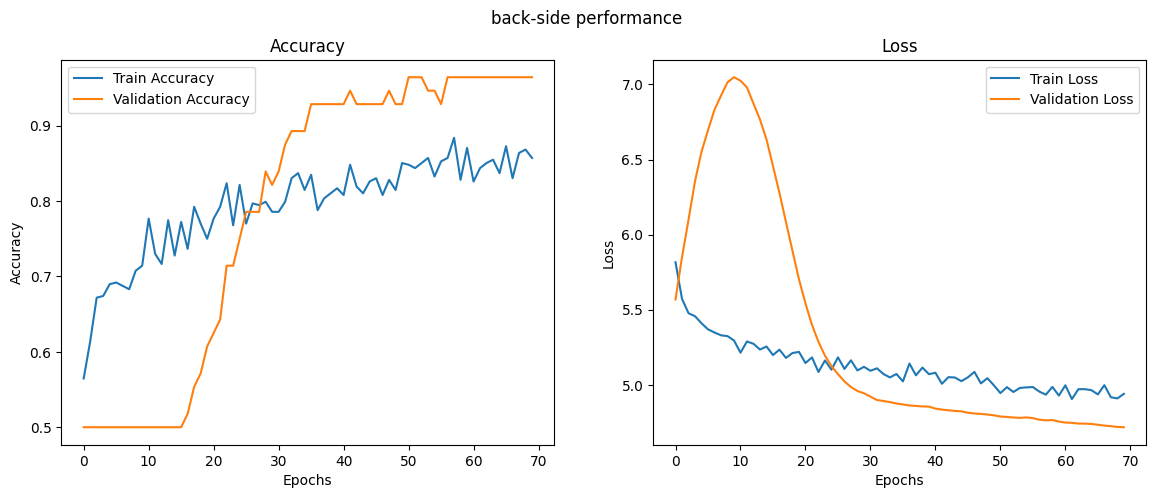

class count {0: 224, 1: 224}
Class Weights: {0: 1.0, 1: 1.0}
Epoch 1/70
28/28 [==============================] - ETA: 0s - loss: 5.7376 - accuracy: 0.5379
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to tarros_3.hdf5
28/28 [==============================] - 47s 2s/step - loss: 5.7376 - accuracy: 0.5379 - val_loss: 5.4167 - val_accuracy: 0.5000
Epoch 2/70


/home/ubuntu/anaconda3/envs/speaking/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - ETA: 0s - loss: 5.6373 - accuracy: 0.5737
Epoch 2: val_accuracy did not improve from 0.50000
28/28 [==============================] - 42s 1s/step - loss: 5.6373 - accuracy: 0.5737 - val_loss: 5.4249 - val_accuracy: 0.5000
Epoch 3/70
28/28 [==============================] - ETA: 0s - loss: 5.5655 - accuracy: 0.5893
Epoch 3: val_accuracy did not improve from 0.50000
28/28 [==============================] - 44s 2s/step - loss: 5.5655 - accuracy: 0.5893 - val_loss: 5.4377 - val_accuracy: 0.5000
Epoch 4/70
28/28 [==============================] - ETA: 0s - loss: 5.6586 - accuracy: 0.5603
Epoch 4: val_accuracy did not improve from 0.50000
28/28 [==============================] - 44s 2s/step - loss: 5.6586 - accuracy: 0.5603 - val_loss: 5.4433 - val_accuracy: 0.5000
Epoch 5/70
28/28 [==============================] - ETA: 0s - loss: 5.6600 - accuracy: 0.6027
Epoch 5: val_accuracy did not improve from 0.50000
28/28 [==============================] - 42s

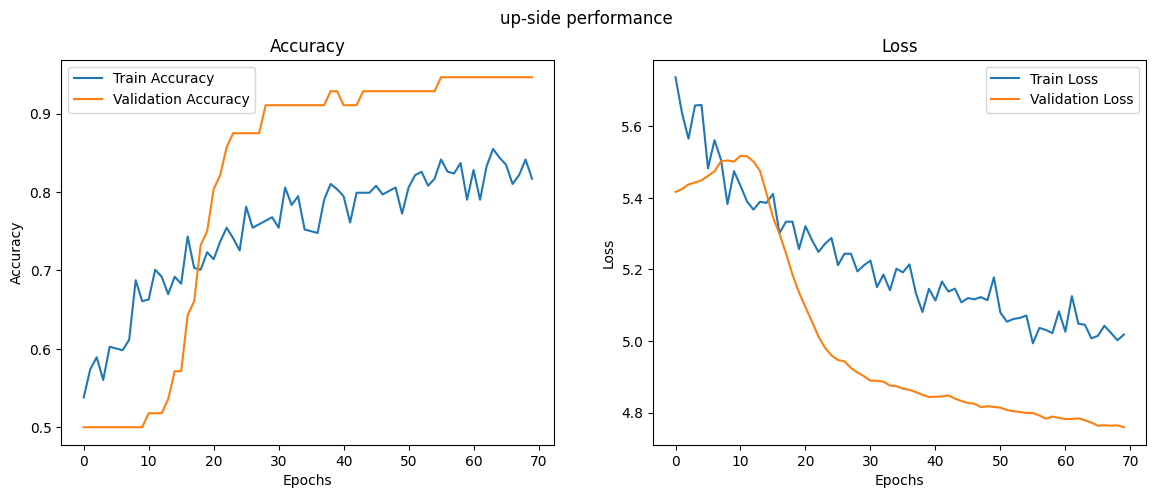

In [130]:
train_network()

In [101]:
def test_model(model_name, directory):
    test_model = load_model(model_name)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_generator = test_datagen.flow_from_directory(directory,
                                 target_size = (64,64),
                                 batch_size = 1,
                                 class_mode = "categorical",
                                 color_mode='grayscale')

    results = test_model.evaluate(test_generator)
    print(results)
    print(test_model.metrics_names)
    return results

In [79]:
default_data_path = "."

## Adam performance
- 20 iterations
- Learning Rate 1e-3
- Adam optimizer

In [83]:
default_data_path = "./backup_data/1_best_performance_adam"

In [84]:
print("Testing model on train split\n")

print("training front site")
test_model(model_name = f'{default_data_path}/tarros_1.hdf5',
           directory = f'./DATASET_improved/1_front/train')

print("training back site")
test_model(model_name = f'{default_data_path}/tarros_2.hdf5',
           directory = f'./DATASET_improved/2_back/train')

print("training up site")
test_model(model_name = f'{default_data_path}/tarros_3.hdf5',
           directory = f'./DATASET_improved/3_up/train')

Testing model on train split

training front site
Found 448 images belonging to 2 classes.
448/448 [==============================] - 40s 88ms/step - loss: 1.8160 - accuracy: 0.9799
training back site
Found 448 images belonging to 2 classes.
448/448 [==============================] - 42s 94ms/step - loss: 1.8324 - accuracy: 0.9621
training up site
Found 448 images belonging to 2 classes.
448/448 [==============================] - 36s 79ms/step - loss: 1.1795 - accuracy: 0.9643


In [85]:
print("Testing model on validation split\n")

print("Validation front site")
test_model(model_name = f'{default_data_path}/tarros_1.hdf5',
           directory = f'./DATASET_improved/1_front/validation')

print("Validation back site")
test_model(model_name = f'{default_data_path}/tarros_2.hdf5',
           directory = f'./DATASET_improved/2_back/validation')

print("Validation up site")
test_model(model_name = f'{default_data_path}/tarros_3.hdf5',
           directory = f'./DATASET_improved/3_up/validation')

Testing model on validation split

Validation front site
Found 56 images belonging to 2 classes.
56/56 [==============================] - 6s 93ms/step - loss: 1.8133 - accuracy: 0.9821
Validation back site
Found 56 images belonging to 2 classes.
56/56 [==============================] - 5s 82ms/step - loss: 1.7945 - accuracy: 0.9821
Validation up site
Found 56 images belonging to 2 classes.
56/56 [==============================] - 5s 88ms/step - loss: 1.1640 - accuracy: 1.0000


In [86]:
print("Testing model on test split\n")

print("Testing front site")
test_model(model_name = f'{default_data_path}/tarros_1.hdf5',
           directory = f'./DATASET_improved/1_front/test')

print("Testing back site")
test_model(model_name = f'{default_data_path}/tarros_2.hdf5',
           directory = f'./DATASET_improved/2_back/test')

print("Testing up site")
test_model(model_name = f'{default_data_path}/tarros_3.hdf5',
           directory = f'./DATASET_improved/3_up/test')

Testing model on test split

Testing front site
Found 56 images belonging to 2 classes.
56/56 [==============================] - 5s 91ms/step - loss: 1.9303 - accuracy: 0.8929
Testing back site
Found 56 images belonging to 2 classes.
56/56 [==============================] - 5s 90ms/step - loss: 1.7999 - accuracy: 0.9643
Testing up site
Found 56 images belonging to 2 classes.
56/56 [==============================] - 5s 90ms/step - loss: 1.1754 - accuracy: 0.9821


## SGD Performance

- 40  iterations
- Learning Rate 5e-3
- Stochastic Gradient Descent optimizer

In [ ]:
default_data_path = "./backup_data/2_best_performance_sgd"

In [ ]:
print("Testing model on train split\n")

print("training front site")
test_model(model_name = f'{default_data_path}/tarros_1.hdf5',
           directory = f'./DATASET_improved/1_front/train')

print("training back site")
test_model(model_name = f'{default_data_path}/tarros_2.hdf5',
           directory = f'./DATASET_improved/2_back/train')

print("training up site")
test_model(model_name = f'{default_data_path}/tarros_3.hdf5',
           directory = f'./DATASET_improved/3_up/train')

Testing model on train split

training front site
Found 448 images belonging to 2 classes.
448/448 [==============================] - 43s 96ms/step - loss: 4.3559 - accuracy: 0.9710
training back site
Found 448 images belonging to 2 classes.
448/448 [==============================] - 41s 90ms/step - loss: 4.4640 - accuracy: 0.9688
training up site
Found 448 images belonging to 2 classes.
448/448 [==============================] - 37s 83ms/step - loss: 3.9867 - accuracy: 1.0000


In [ ]:
print("Testing model on validation split\n")

print("Validation front site")
test_model(model_name = f'{default_data_path}/tarros_1.hdf5',
           directory = f'./DATASET_improved/1_front/validation')

print("Validation back site")
test_model(model_name = f'{default_data_path}/tarros_2.hdf5',
           directory = f'./DATASET_improved/2_back/validation')

print("Validation up site")
test_model(model_name = f'{default_data_path}/tarros_3.hdf5',
           directory = f'./DATASET_improved/3_up/validation')

Testing model on validation split

Validation front site
Found 56 images belonging to 2 classes.
56/56 [==============================] - 5s 91ms/step - loss: 1.8133 - accuracy: 0.9821
[1.8132890462875366, 0.9821428656578064]
['loss', 'accuracy']
Validation back site
Found 56 images belonging to 2 classes.
56/56 [==============================] - 4s 72ms/step - loss: 1.7945 - accuracy: 0.9821
[1.7945106029510498, 0.9821428656578064]
['loss', 'accuracy']
Validation up site
Found 56 images belonging to 2 classes.
56/56 [==============================] - 5s 92ms/step - loss: 1.1640 - accuracy: 1.0000
[1.1640321016311646, 1.0]
['loss', 'accuracy']


In [ ]:
print("Testing model on test split\n")

print("Testing front site")
test_model(model_name = f'{default_data_path}/tarros_1.hdf5',
           directory = f'./DATASET_improved/1_front/test')

print("Testing back site")
test_model(model_name = f'{default_data_path}/tarros_2.hdf5',
           directory = f'./DATASET_improved/2_back/test')

print("Testing up site")
test_model(model_name = f'{default_data_path}/tarros_3.hdf5',
           directory = f'./DATASET_improved/3_up/test')

Testing model on test split

Testing front site


Found 56 images belonging to 2 classes.
56/56 [==============================] - 5s 82ms/step - loss: 4.4223 - accuracy: 0.9643
Testing back site
Found 56 images belonging to 2 classes.
56/56 [==============================] - 5s 76ms/step - loss: 4.4692 - accuracy: 0.9821
Testing up site
Found 56 images belonging to 2 classes.
56/56 [==============================] - 5s 89ms/step - loss: 3.9934 - accuracy: 1.0000


## Adamw performance

- 50 iterations
- Learning Rate 1e-4
- Adamw optimizer

In [104]:
default_data_path = "./backup_data/3_best_performance_adamw"

In [105]:
print("Testing model on train split\n")

print("training front site")
test_model(model_name = f'{default_data_path}/tarros_1.hdf5',
           directory = f'./DATASET_improved/1_front/train')

print("training back site")
test_model(model_name = f'{default_data_path}/tarros_2.hdf5',
           directory = f'./DATASET_improved/2_back/train')

print("training up site")
test_model(model_name = f'{default_data_path}/tarros_3.hdf5',
           directory = f'./DATASET_improved/3_up/train')

Testing model on train split

training front site
Found 448 images belonging to 2 classes.
448/448 [==============================] - 39s 86ms/step - loss: 4.4690 - accuracy: 0.9732
[4.4690165519714355, 0.9732142686843872]
['loss', 'accuracy']
training back site
Found 448 images belonging to 2 classes.
448/448 [==============================] - 39s 87ms/step - loss: 4.1279 - accuracy: 0.9933
[4.127902030944824, 0.9933035969734192]
['loss', 'accuracy']
training up site
Found 448 images belonging to 2 classes.
448/448 [==============================] - 42s 92ms/step - loss: 4.2468 - accuracy: 0.9866
[4.246816158294678, 0.9866071343421936]
['loss', 'accuracy']


[4.246816158294678, 0.9866071343421936]

In [106]:
print("Testing model on validation split\n")

print("Validation front site")
test_model(model_name = f'{default_data_path}/tarros_1.hdf5',
           directory = f'./DATASET_improved/1_front/validation')

print("Validation back site")
test_model(model_name = f'{default_data_path}/tarros_2.hdf5',
           directory = f'./DATASET_improved/2_back/validation')

print("Validation up site")
test_model(model_name = f'{default_data_path}/tarros_3.hdf5',
           directory = f'./DATASET_improved/3_up/validation')

Testing model on validation split

Validation front site
Found 56 images belonging to 2 classes.
56/56 [==============================] - 6s 93ms/step - loss: 4.4693 - accuracy: 0.9821
[4.469333171844482, 0.9821428656578064]
['loss', 'accuracy']
Validation back site
Found 56 images belonging to 2 classes.
56/56 [==============================] - 6s 92ms/step - loss: 4.1186 - accuracy: 1.0000
[4.118551254272461, 1.0]
['loss', 'accuracy']
Validation up site
Found 56 images belonging to 2 classes.
56/56 [==============================] - 5s 80ms/step - loss: 4.2381 - accuracy: 1.0000
[4.238096714019775, 1.0]
['loss', 'accuracy']


[4.238096714019775, 1.0]

In [107]:
print("Testing model on test split\n")

print("Testing front site")
test_model(model_name = f'{default_data_path}/tarros_1.hdf5',
           directory = f'./DATASET_improved/1_front/test')

print("Testing back site")
test_model(model_name = f'{default_data_path}/tarros_2.hdf5',
           directory = f'./DATASET_improved/2_back/test')

print("Testing up site")
test_model(model_name = f'{default_data_path}/tarros_3.hdf5',
           directory = f'./DATASET_improved/3_up/test')

Testing model on test split

Testing front site
Found 56 images belonging to 2 classes.
56/56 [==============================] - 5s 74ms/step - loss: 4.5992 - accuracy: 0.9107
[4.599236488342285, 0.9107142686843872]
['loss', 'accuracy']
Testing back site
Found 56 images belonging to 2 classes.
56/56 [==============================] - 6s 93ms/step - loss: 4.1134 - accuracy: 1.0000
[4.113375663757324, 1.0]
['loss', 'accuracy']
Testing up site
Found 56 images belonging to 2 classes.
56/56 [==============================] - 6s 94ms/step - loss: 4.2505 - accuracy: 0.9821
[4.250495433807373, 0.9821428656578064]
['loss', 'accuracy']


[4.250495433807373, 0.9821428656578064]

## Adam Again (Less LR more epochs)

- 70 iterations
- Learning Rate 1e-5
- Adam optimizer

In [133]:
default_data_path = "./backup_data/4_best_performance_adam_larger_train_lower_lr"

In [134]:
print("Testing model on train split\n")

print("training front site")
test_model(model_name = f'{default_data_path}/tarros_1.hdf5',
           directory = f'./DATASET_improved/1_front/train')

print("training back site")
test_model(model_name = f'{default_data_path}/tarros_2.hdf5',
           directory = f'./DATASET_improved/2_back/train')

print("training up site")
test_model(model_name = f'{default_data_path}/tarros_3.hdf5',
           directory = f'./DATASET_improved/3_up/train')

Testing model on train split

training front site
Found 448 images belonging to 2 classes.
448/448 [==============================] - 41s 90ms/step - loss: 4.8141 - accuracy: 0.9375
[4.814067840576172, 0.9375]
['loss', 'accuracy']
training back site
Found 448 images belonging to 2 classes.
448/448 [==============================] - 35s 78ms/step - loss: 4.7819 - accuracy: 0.9509
[4.781905651092529, 0.9508928656578064]
['loss', 'accuracy']
training up site
Found 448 images belonging to 2 classes.
448/448 [==============================] - 38s 84ms/step - loss: 4.7997 - accuracy: 0.9554
[4.799736022949219, 0.9553571343421936]
['loss', 'accuracy']


[4.799736022949219, 0.9553571343421936]

In [135]:
print("Testing model on validation split\n")

print("Validation front site")
test_model(model_name = f'{default_data_path}/tarros_1.hdf5',
           directory = f'./DATASET_improved/1_front/validation')

print("Validation back site")
test_model(model_name = f'{default_data_path}/tarros_2.hdf5',
           directory = f'./DATASET_improved/2_back/validation')

print("Validation up site")
test_model(model_name = f'{default_data_path}/tarros_3.hdf5',
           directory = f'./DATASET_improved/3_up/validation')

Testing model on validation split

Validation front site
Found 56 images belonging to 2 classes.
56/56 [==============================] - 5s 89ms/step - loss: 4.7846 - accuracy: 0.9643
[4.784558296203613, 0.9642857313156128]
['loss', 'accuracy']
Validation back site
Found 56 images belonging to 2 classes.
56/56 [==============================] - 6s 93ms/step - loss: 4.7890 - accuracy: 0.9643
[4.788991451263428, 0.9642857313156128]
['loss', 'accuracy']
Validation up site
Found 56 images belonging to 2 classes.
56/56 [==============================] - 5s 84ms/step - loss: 4.7985 - accuracy: 0.9464
[4.798493385314941, 0.9464285969734192]
['loss', 'accuracy']


[4.798493385314941, 0.9464285969734192]

In [136]:
print("Testing model on test split\n")

print("Testing front site")
test_model(model_name = f'{default_data_path}/tarros_1.hdf5',
           directory = f'./DATASET_improved/1_front/test')

print("Testing back site")
test_model(model_name = f'{default_data_path}/tarros_2.hdf5',
           directory = f'./DATASET_improved/2_back/test')

print("Testing up site")
test_model(model_name = f'{default_data_path}/tarros_3.hdf5',
           directory = f'./DATASET_improved/3_up/test')

Testing model on test split

Testing front site
Found 56 images belonging to 2 classes.
56/56 [==============================] - 5s 78ms/step - loss: 4.8775 - accuracy: 0.8750
[4.877537727355957, 0.875]
['loss', 'accuracy']
Testing back site
Found 56 images belonging to 2 classes.
56/56 [==============================] - 5s 89ms/step - loss: 4.8144 - accuracy: 0.9464
[4.8143630027771, 0.9464285969734192]
['loss', 'accuracy']
Testing up site
Found 56 images belonging to 2 classes.
56/56 [==============================] - 5s 79ms/step - loss: 4.8047 - accuracy: 0.9643
[4.804715156555176, 0.9642857313156128]
['loss', 'accuracy']


[4.804715156555176, 0.9642857313156128]